In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import glob

from datetime import datetime, date

## To-do list
- Get clear on accuracy formula and calculations
- Standard deviations
- Optimization
- Repeat using a (non-deep learning) classifier of your choice.
- Discussions

In [2]:
def computeHoG(image, winSize, blockSize, blockStride, cellSize,
                               nbins, RESIZE_DIM, cell_size, block_size):
    
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

    n_cells = (RESIZE_DIM // cell_size[0], RESIZE_DIM // cell_size[1])

    # Compute HoG features
    hog_feats = hog.compute(image)
    hog_feats = hog_feats.reshape(n_cells[1]-block_size[1]+1,
                                  n_cells[0]-block_size[0]+1,
                                  block_size[0], block_size[1], nbins)
    hog_feats = hog_feats.transpose((1, 0, 2, 3, 4))  # index blocks by rows first

    # hog_feats now contains the gradient amplitudes for each direction,
    #for each cell of its group for each group.
    # Indexing is by rows then columns.

    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

    for off_y in range(block_size[0]):
        for off_x in range(block_size[1]):
            gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                      off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                       off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

    # Average gradients
    gradients /= cell_count

    gradients = gradients.reshape((1, -1))
    return gradients

def resizeImage(image, dimension):
    imy, imx = image.shape[0:2]
    M = np.float32([[dimension/imx, 0, 0], [0, dimension/imy, 0]])
    image = cv2.warpAffine(image, M, (RESIZE_DIM, RESIZE_DIM))
    return image

In [3]:
""" With limited image count"""

#display
startGlobal = datetime.time(datetime.now())

# #testing
categoriesTest  = [
    "car",
    "background",
    "pickup_truck",
    "articulated_truck",
    "bus",
    "work_van",
    "pedestrian",
    "single_unit_truck",
    "bicycle",
    "motorcycle",
    "non-motorized_vehicle"]
#endTesting
#^We notice that runtime is minimized of operations occur on the largest categories first
numCategories = len(categoriesTest)

"""
################################################
 Setting a limit of 2000 images to speed up
 computations and balance proportion of images
################################################
"""

#TEMP
sumIm = 0
for i in range(numCategories):
    path = ("MIO-TCD-Classification/train/%s/*.jpg" % categoriesTest[i])
#     numImages = len(glob.glob(path))
    if len(glob.glob(path)) >= 2000: numImages = 2000
    elif len(glob.glob(path)) < 2000: numImages = len(glob.glob(path))
    sumIm = sumIm + numImages
#End TEMP

RESIZE_DIM = 64
# totalNumIm = 519164 #MAY GIVE MEMORY ERROR
#testing
totalNumIm = sumIm
#End testing
globalImCtr = 0

#HoG variables
#Raw variables
cell_size = (4,4)
block_size = (4, 4)

#variables for computation
winSize = (RESIZE_DIM // cell_size[1] * cell_size[1], RESIZE_DIM // cell_size[0] * cell_size[0] )
blockSize = (block_size[1] * cell_size[1], block_size[0] * cell_size[0])
blockStride = (cell_size[1], cell_size[0])
cellSize = (cell_size[1], cell_size[0])
nbins = 8
#End HoG variables

totalNumFeatures = RESIZE_DIM // cell_size[1] * RESIZE_DIM // cell_size[0] * nbins

#array initialization
labelsArray = np.zeros(totalNumIm, dtype=np.int)
featuresArray = np.zeros((totalNumIm, totalNumFeatures))
indexArray = np.arange(totalNumIm, dtype=np.int)
np.random.shuffle(indexArray)         

# Read input images category by category
for i in range(numCategories):
    start = datetime.time(datetime.now())

    #specifying path to images
    path = ("MIO-TCD-Classification/train/%s/*.jpg" % categoriesTest[i])

    #Variable initializations
    categoryImgCnt = 0
    nextPctg = 5
    numImages = len(glob.glob(path))
    if numImages > 2000: numImages = 2000

    #display
    print("Loading Images for category:    >>>" + categoriesTest[i] + "<<<    " + str(numImages) + " images of " 
          + str(len(glob.glob(path))) + " total images")
    print("    Percentage Completed: 0%-", end='')

    # for each image in the category folder
#     for file in glob.glob(path):
    imgCounter = 0
    for file in glob.glob(path):
        if imgCounter < numImages:
            imgCounter += 1
            #read, convert color, get features, stor info
            image = cv2.imread(file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            #resizing IF NECESSARY
            #TRY to do HoG without resizing image. to be discussed
            image = resizeImage(image, RESIZE_DIM)
            #end resize

            #Computing features
            #HoG features
            gradients = computeHoG(image, winSize, blockSize, blockStride, cellSize,
                                   nbins, RESIZE_DIM, cell_size, block_size)

            randomIndex = indexArray[globalImCtr]
            featuresArray[randomIndex] = gradients
            labelsArray[randomIndex] = i
            #End Feature computation

            #variable update
            globalImCtr = globalImCtr + 1
            categoryImgCnt = categoryImgCnt + 1

            #display
            if (int(categoryImgCnt*100/numImages)) == nextPctg:
                print(str(nextPctg) + "%", end='')
                if nextPctg != 100 : print("-", end='')
                nextPctg = nextPctg + 5
        else:
            # dont load more than 2000 imgs
            break
    #display        
    print("")
#     print("loaded " + str(imgCounter) + " images")
    end = datetime.time(datetime.now())
    print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))

#display
endGlobal = datetime.time(datetime.now())
duration = datetime.combine(date.today(), endGlobal) - datetime.combine(date.today(), startGlobal)
print(">Total duration: " + str(duration))
print(labelsArray[:100])

Loading Images for category:    >>>car<<<    2000 images of 260518 total images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:13.385989
Loading Images for category:    >>>background<<<    2000 images of 160000 total images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:09.367252
Loading Images for category:    >>>pickup_truck<<<    2000 images of 50906 total images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:08.044848
Loading Images for category:    >>>articulated_truck<<<    2000 images of 10346 total images
    Percentage Completed: 0%-5%-10%-15%-20%-25%-30%-35%-40%-45%-50%-55%-60%-65%-70%-75%-80%-85%-90%-95%-100%
    Duration: 0:00:08.285835
Loading Images for category:    >>>bus<<<    2000 images of 10316 total images
    Percentage Comple

In [4]:
print("Size of featuresArray: ", featuresArray.shape)
print("Size of labelsArray: ", labelsArray.shape)

Size of featuresArray:  (21733, 2048)
Size of labelsArray:  (21733,)


Updates:
  Note: 
    This is the deep learning implementation of the classifier.
    In this implementation we use an SVM classifier
    Precision: Of the predictions made for class C, what fraction was correct?
    Recall: ”Of the samples for class C, how many were correctly predicted?

  Classifiers can be loaded if files classifier_0.sav - classifier_9.sav are in the same folder as this .ipynb file.

Would you like to build or load the SVM classifiers? load

  Loading classifier >>classifier_0.sav<<


C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 0
    Duration: 0:02:30.855593
  For subset 0:
    For category car: TP=155, FP=59, FN=40, TN=1919
      Accuracy = 95.44%      Precision = 72.43%      Recall = 79.49%
    For category background: TP=155, FP=61, FN=43, TN=1914
      Accuracy = 95.21%      Precision = 71.76%      Recall = 78.28%
    For category pickup_truck: TP=118, FP=71, FN=73, TN=1911
      Accuracy = 93.37%      Precision = 62.43%      Recall = 61.78%
    For category articulated_truck: TP=121, FP=97, FN=61, TN=1894
      Accuracy = 92.73%      Precision = 55.50%      Recall = 66.48%
    For category bus: TP=142, FP=83, FN=65, TN=1883
      Accuracy = 93.19%      Precision = 63.11%      Recall = 68.60%
    For category work_van: TP=151, FP=62, FN=88, TN=1872
      Accuracy = 93.10%      Precision = 70.89%      Recall = 63.18%
    For category pedestrian: TP=134, FP=74, FN=63, TN=1902
      Accuracy = 93.70%      Precision = 64.42%      Recall = 68.02%
    For category single_uni

C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 1
    Duration: 0:02:28.882906
  For subset 1:
    For category car: TP=150, FP=77, FN=51, TN=1895
      Accuracy = 94.11%      Precision = 66.08%      Recall = 74.63%
    For category background: TP=145, FP=48, FN=52, TN=1928
      Accuracy = 95.40%      Precision = 75.13%      Recall = 73.60%
    For category pickup_truck: TP=124, FP=65, FN=91, TN=1893
      Accuracy = 92.82%      Precision = 65.61%      Recall = 57.67%
    For category articulated_truck: TP=131, FP=116, FN=78, TN=1848
      Accuracy = 91.07%      Precision = 53.04%      Recall = 62.68%
    For category bus: TP=133, FP=65, FN=47, TN=1928
      Accuracy = 94.85%      Precision = 67.17%      Recall = 73.89%
    For category work_van: TP=125, FP=67, FN=66, TN=1915
      Accuracy = 93.88%      Precision = 65.10%      Recall = 65.45%
    For category pedestrian: TP=107, FP=81, FN=53, TN=1932
      Accuracy = 93.83%      Precision = 56.91%      Recall = 66.88%
    For category single_un

C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 2
    Duration: 0:02:28.721334
  For subset 2:
    For category car: TP=139, FP=50, FN=48, TN=1936
      Accuracy = 95.49%      Precision = 73.54%      Recall = 74.33%
    For category background: TP=171, FP=66, FN=35, TN=1901
      Accuracy = 95.35%      Precision = 72.15%      Recall = 83.01%
    For category pickup_truck: TP=134, FP=73, FN=63, TN=1903
      Accuracy = 93.74%      Precision = 64.73%      Recall = 68.02%
    For category articulated_truck: TP=120, FP=103, FN=81, TN=1869
      Accuracy = 91.53%      Precision = 53.81%      Recall = 59.70%
    For category bus: TP=130, FP=84, FN=69, TN=1890
      Accuracy = 92.96%      Precision = 60.75%      Recall = 65.33%
    For category work_van: TP=116, FP=75, FN=64, TN=1918
      Accuracy = 93.60%      Precision = 60.73%      Recall = 64.44%
    For category pedestrian: TP=150, FP=83, FN=69, TN=1871
      Accuracy = 93.01%      Precision = 64.38%      Recall = 68.49%
    For category single_un

C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 3
    Duration: 0:02:28.237590
  For subset 3:
    For category car: TP=155, FP=67, FN=52, TN=1899
      Accuracy = 94.52%      Precision = 69.82%      Recall = 74.88%
    For category background: TP=162, FP=53, FN=48, TN=1910
      Accuracy = 95.35%      Precision = 75.35%      Recall = 77.14%
    For category pickup_truck: TP=125, FP=84, FN=87, TN=1877
      Accuracy = 92.13%      Precision = 59.81%      Recall = 58.96%
    For category articulated_truck: TP=121, FP=97, FN=88, TN=1867
      Accuracy = 91.49%      Precision = 55.50%      Recall = 57.89%
    For category bus: TP=118, FP=80, FN=64, TN=1911
      Accuracy = 93.37%      Precision = 59.60%      Recall = 64.84%
    For category work_van: TP=133, FP=89, FN=74, TN=1877
      Accuracy = 92.50%      Precision = 59.91%      Recall = 64.25%
    For category pedestrian: TP=142, FP=61, FN=64, TN=1906
      Accuracy = 94.25%      Precision = 69.95%      Recall = 68.93%
    For category single_uni

C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 4
    Duration: 0:02:35.120188
  For subset 4:
    For category car: TP=168, FP=71, FN=44, TN=1890
      Accuracy = 94.71%      Precision = 70.29%      Recall = 79.25%
    For category background: TP=154, FP=60, FN=35, TN=1924
      Accuracy = 95.63%      Precision = 71.96%      Recall = 81.48%
    For category pickup_truck: TP=111, FP=62, FN=78, TN=1922
      Accuracy = 93.56%      Precision = 64.16%      Recall = 58.73%
    For category articulated_truck: TP=123, FP=120, FN=79, TN=1851
      Accuracy = 90.84%      Precision = 50.62%      Recall = 60.89%
    For category bus: TP=129, FP=72, FN=75, TN=1897
      Accuracy = 93.24%      Precision = 64.18%      Recall = 63.24%
    For category work_van: TP=117, FP=91, FN=80, TN=1885
      Accuracy = 92.13%      Precision = 56.25%      Recall = 59.39%
    For category pedestrian: TP=123, FP=63, FN=72, TN=1915
      Accuracy = 93.79%      Precision = 66.13%      Recall = 63.08%
    For category single_un

C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 5
    Duration: 0:02:28.235636
  For subset 5:
    For category car: TP=149, FP=50, FN=43, TN=1931
      Accuracy = 95.72%      Precision = 74.87%      Recall = 77.60%
    For category background: TP=158, FP=57, FN=42, TN=1916
      Accuracy = 95.44%      Precision = 73.49%      Recall = 79.00%
    For category pickup_truck: TP=127, FP=67, FN=71, TN=1908
      Accuracy = 93.65%      Precision = 65.46%      Recall = 64.14%
    For category articulated_truck: TP=119, FP=96, FN=80, TN=1878
      Accuracy = 91.90%      Precision = 55.35%      Recall = 59.80%
    For category bus: TP=150, FP=86, FN=64, TN=1873
      Accuracy = 93.10%      Precision = 63.56%      Recall = 70.09%
    For category work_van: TP=117, FP=80, FN=73, TN=1903
      Accuracy = 92.96%      Precision = 59.39%      Recall = 61.58%
    For category pedestrian: TP=150, FP=70, FN=58, TN=1895
      Accuracy = 94.11%      Precision = 68.18%      Recall = 72.12%
    For category single_uni

C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 6
    Duration: 0:02:29.573024
  For subset 6:
    For category car: TP=148, FP=71, FN=43, TN=1911
      Accuracy = 94.75%      Precision = 67.58%      Recall = 77.49%
    For category background: TP=173, FP=66, FN=43, TN=1891
      Accuracy = 94.98%      Precision = 72.38%      Recall = 80.09%
    For category pickup_truck: TP=117, FP=68, FN=80, TN=1908
      Accuracy = 93.19%      Precision = 63.24%      Recall = 59.39%
    For category articulated_truck: TP=122, FP=100, FN=78, TN=1873
      Accuracy = 91.81%      Precision = 54.95%      Recall = 61.00%
    For category bus: TP=153, FP=73, FN=56, TN=1891
      Accuracy = 94.06%      Precision = 67.70%      Recall = 73.21%
    For category work_van: TP=134, FP=66, FN=76, TN=1897
      Accuracy = 93.47%      Precision = 67.00%      Recall = 63.81%
    For category pedestrian: TP=132, FP=85, FN=56, TN=1900
      Accuracy = 93.51%      Precision = 60.83%      Recall = 70.21%
    For category single_un

C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 7
    Duration: 0:02:30.490571
  For subset 7:
    For category car: TP=150, FP=56, FN=58, TN=1909
      Accuracy = 94.75%      Precision = 72.82%      Recall = 72.12%
    For category background: TP=140, FP=49, FN=40, TN=1944
      Accuracy = 95.90%      Precision = 74.07%      Recall = 77.78%
    For category pickup_truck: TP=125, FP=89, FN=63, TN=1896
      Accuracy = 93.01%      Precision = 58.41%      Recall = 66.49%
    For category articulated_truck: TP=133, FP=98, FN=69, TN=1873
      Accuracy = 92.31%      Precision = 57.58%      Recall = 65.84%
    For category bus: TP=138, FP=88, FN=66, TN=1881
      Accuracy = 92.91%      Precision = 61.06%      Recall = 67.65%
    For category work_van: TP=122, FP=66, FN=72, TN=1913
      Accuracy = 93.65%      Precision = 64.89%      Recall = 62.89%
    For category pedestrian: TP=154, FP=81, FN=59, TN=1879
      Accuracy = 93.56%      Precision = 65.53%      Recall = 72.30%
    For category single_uni

C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 8
    Duration: 0:02:31.109950
  For subset 8:
    For category car: TP=151, FP=67, FN=54, TN=1901
      Accuracy = 94.43%      Precision = 69.27%      Recall = 73.66%
    For category background: TP=160, FP=56, FN=38, TN=1919
      Accuracy = 95.67%      Precision = 74.07%      Recall = 80.81%
    For category pickup_truck: TP=120, FP=77, FN=77, TN=1899
      Accuracy = 92.91%      Precision = 60.91%      Recall = 60.91%
    For category articulated_truck: TP=145, FP=101, FN=70, TN=1857
      Accuracy = 92.13%      Precision = 58.94%      Recall = 67.44%
    For category bus: TP=125, FP=68, FN=66, TN=1914
      Accuracy = 93.83%      Precision = 64.77%      Recall = 65.45%
    For category work_van: TP=119, FP=75, FN=72, TN=1907
      Accuracy = 93.24%      Precision = 61.34%      Recall = 62.30%
    For category pedestrian: TP=146, FP=73, FN=62, TN=1892
      Accuracy = 93.79%      Precision = 66.67%      Recall = 70.19%
    For category single_un

C:\Anaconda\envs\new_root\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator SVC from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


  Getting predictions for classifier 9
    Duration: 0:03:12.020988
  For subset 9:
    For category car: TP=150, FP=53, FN=52, TN=1918
      Accuracy = 95.17%      Precision = 73.89%      Recall = 74.26%
    For category background: TP=168, FP=68, FN=38, TN=1899
      Accuracy = 95.12%      Precision = 71.19%      Recall = 81.55%
    For category pickup_truck: TP=143, FP=70, FN=72, TN=1888
      Accuracy = 93.47%      Precision = 67.14%      Recall = 66.51%
    For category articulated_truck: TP=106, FP=93, FN=75, TN=1899
      Accuracy = 92.27%      Precision = 53.27%      Recall = 58.56%
    For category bus: TP=149, FP=73, FN=61, TN=1890
      Accuracy = 93.83%      Precision = 67.12%      Recall = 70.95%
    For category work_van: TP=122, FP=71, FN=78, TN=1902
      Accuracy = 93.14%      Precision = 63.21%      Recall = 61.00%
    For category pedestrian: TP=140, FP=88, FN=66, TN=1879
      Accuracy = 92.91%      Precision = 61.40%      Recall = 67.96%
    For category single_uni

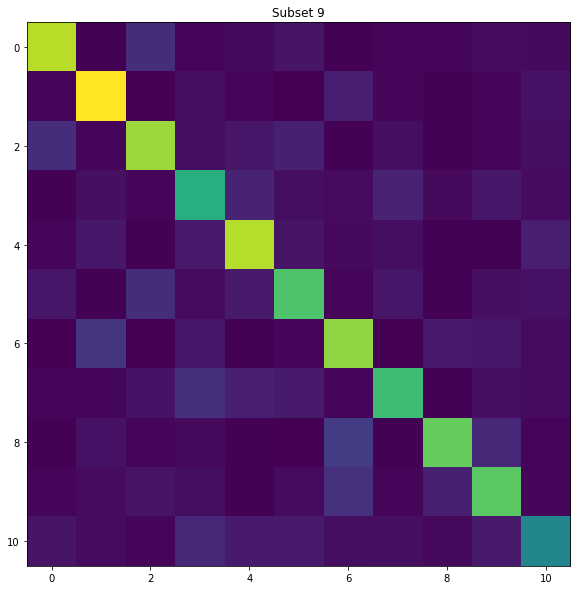

Legend:
  0: car
  1: background
  2: pickup_truck
  3: articulated_truck
  4: bus
  5: work_van
  6: pedestrian
  7: single_unit_truck
  8: bicycle
  9: motorcycle
  10: non-motorized_vehicle

Overall average accuracy is 93.74%
Standard deviation is 0.001062
Overall average precision is 65.59%
Overall average recall is 65.36%

Done, total duration: 0:25:54.775404


In [6]:
print("Updates:")

print("  Note: ")
print("    This is the deep learning implementation of the classifier.")
print("    In this implementation we use an SVM classifier")
print("    Precision: Of the predictions made for class C, what fraction was correct?")
print("    Recall: ”Of the samples for class C, how many were correctly predicted?\n")
print("  Classifiers can be loaded if files classifier_0.sav - classifier_9.sav are in the same" 
     + " folder as this .ipynb file.\n")

realStart = datetime.time(datetime.now())

numSubset = 10

subsetSize = featuresArray.shape[0]//numSubset
    
accuracyArray = []
precisionArray = []
recallArray = []

sqrdDiff = []

while(1):
    inputStr = input("Would you like to build or load the SVM classifiers? ")
    
    inputStr = inputStr.lower()
    
    if inputStr == 'exit':
        print("  Program exiting\n")
        break
    
    elif inputStr == 'help':
        print("  Available commands: Build, Load, Help, Exit\n")
    
    elif inputStr == 'build' or inputStr == 'load':
        # proceed and build or load classifiers
        realStart = datetime.time(datetime.now())
       
        for subsetIndex in range(numSubset):
            
            precArray = []
            recArray = []
            
            data_test = featuresArray[subsetIndex*subsetSize:(subsetIndex+1)*subsetSize]
            labels_test = labelsArray[subsetIndex*subsetSize:(subsetIndex+1)*subsetSize]
    
            data_train = np.concatenate((featuresArray[:subsetIndex*subsetSize], 
                                         featuresArray[(subsetIndex+1)*subsetSize:]), axis = 0)
            labels_train = np.concatenate((labelsArray[:subsetIndex*subsetSize], 
                                           labelsArray[(subsetIndex+1)*subsetSize:]), axis = 0)
    
            ################################################
            """Building the classifiers"""
            if inputStr == 'build':
                while(subsetIndex==0):
                    inputSave = input("  Would you like to save the classifiers? ")
                    inputSave = inputSave.lower()
                    
                    if inputSave == 'no':
                        save = 0
                        print("    Classifiers will not be saved\n")
                        break
                    
                    elif inputSave == 'yes':
                        save = 1
                        print("    Classifiers will be saved\n")
                        break
                    
                    else:
                        print("    Invalid input -> 'yes' or 'no'\n")
                    
                print("\n  Creating classifier " + str(subsetIndex))
                start = datetime.time(datetime.now())
                clf = svm.SVC(C = 100.) # default kernel='rfb'
                clf.fit(data_train, labels_train)
                end = datetime.time(datetime.now())
                print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
                
                """Saving the classifiers"""
                if save == 1:
                    filename = ('classifier_%i.sav' % subsetIndex)
                    print("  Saving classifier " + str(subsetIndex) + " as >>" + filename + "<<")
                    joblib.dump(clf, filename)

            ################################################
            
            ################################################
            
            elif inputStr == 'load':
                """Loading the classifiers"""
                filename = ('classifier_%i.sav' % subsetIndex)
                print("\n  Loading classifier >>" + filename + "<<")
                clf = joblib.load(filename)
            ################################################
    
            print("  Getting predictions for classifier " + str(subsetIndex))
            start = datetime.time(datetime.now())
            prediction = clf.predict(data_test)
            end = datetime.time(datetime.now())
            print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
    
            # Precision
            # for each class, get the precision (then average of all classes for all subset?)
            print("  For subset " + str(subsetIndex) + ":")
    
            totalTP = 0
            totalTN = 0
    
            for category in range(numCategories):
                TP = 0
                FP = 0
                FN = 0
                TN = 0
                for n in range(len(prediction)):
                    if prediction[n] == category:
                        if labels_test[n] == category:
                            # got a true positive
                            TP += 1
                            totalTP += 1
                        else:
                            # got a false positive
                            FP += 1
                        continue
    
                    if prediction[n] != category:
                        if labels_test[n] == category:
                            # got a false negative
                            FN += 1
                        else:
                            # got a true negative
                            TN += 1
                            totalTN += 1
                        continue
    
                    else: print("    Error at n=" + str(n) + "-> Predicted: " + str(prediction[n])
                                + ", Correct: " + str(labels_test[n]))
    
                print("    For category " + str(categoriesTest[category]) + ": TP=" + str(TP) + ", FP=" + str(FP) 
                      + ", FN=" + str(FN) + ", TN=" + str(TN))
    
                accuracyCalc = (TP+TN)/(TP+TN+FP+FN)*100
                precision = TP/(TP+FP)*100
                recall = TP/(TP+FN)*100
                
                precArray.append(precision)
                recArray.append(recall)
    
                print("      Accuracy = %.2f" % accuracyCalc + "%", end='')
                print("      Precision = %.2f" % precision + "%", end='')
                print("      Recall = %.2f" % recall + "%")
            
            subAcc = (totalTP+totalTN)/len(prediction)*100/numCategories
            print("  Average accuracy of subset %i = %.2f" % (subsetIndex, subAcc) + "%")
            accuracyArray.append(subAcc)
            
            subPrec = np.sum(precArray)/numCategories
            print("  Average precision2 of subset %i = %.2f" % (subsetIndex, subPrec) + "%")
            precisionArray.append(subPrec)
            
            subRecall = np.sum(recArray)/numCategories
            print("  Average recall of subset %i = %.2f" % (subsetIndex, subRecall) + "%")
            recallArray.append(subRecall)
            
            # Confusion Matrix for last subset only
            ################################################
            # Do we only need one?
            ################################################
            if subsetIndex == numSubset-1:
                print("  Creating confusion matrix " + str(subsetIndex))
                start = datetime.time(datetime.now())
                confMat = confusion_matrix(labels_test, prediction)
                end = datetime.time(datetime.now())
                print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
    
                plt.figure(figsize=(10,10))
                plt.imshow(confMat), plt.title("Subset " + str(subsetIndex))
                plt.show()
    
                # display categories and their label
                print("Legend:")
                for cat in range(len(categoriesTest)):
                    print("  " + str(cat) + ": " + str(categoriesTest[cat]))
    
        # calculate the overall average accuracy
        avgAccuracy = 0
        avgAccuracy = np.sum(accuracyArray)/len(accuracyArray)
        print("\nOverall average accuracy is %.2f" % (avgAccuracy) + "%")
        
        # calculate the standard deviation
        accArray = np.asarray(accuracyArray)
        sqrdDiff = ((accArray-avgAccuracy)/100)**2
        stdDev = np.sqrt(np.sum(sqrdDiff)/len(sqrdDiff))
        print("Standard deviation is %f" % stdDev)
        
        # calculate the overall average precision
        avgPrecision = 0
        avgPrecision = np.sum(precisionArray)/len(precisionArray)
        print("Overall average precision is %.2f" % (avgPrecision) + "%")
        
        #calculate the overall average recall
        avgRecall = 0
        avgRecall = np.sum(recallArray)/len(recallArray)
        print("Overall average recall is %.2f" % (avgRecall) + "%")
    
        realEnd = datetime.time(datetime.now())
        print("\nDone, total duration: " + str(datetime.combine(date.today(), realEnd) 
                                               - datetime.combine(date.today(), realStart)))
        break
    
    else:
        # not a valid input
        print("  '" + inputStr + "' is not a valid input -> type 'help' for help\n")

Updates:
  Note: 
    This is the non-deep learning implementation of the classifier.
    In this implementation we use a kneighbor classifier
    Precision: Of the predictions made for class C, what fraction was correct?
    Recall: ”Of the samples for class C, how many were correctly predicted?

  Classifiers can be loaded if files kNeighborsclassifier_0.sav - kNeighborsclassifier_9.sav are in the same folder as this .ipynb file.

Would you like to build or load the kNeighbors classifiers? build
  Would you like to save the classifiers? no
    Classifiers will not be saved


  Creating classifier 0
    Duration: 0:00:07.590672
  Getting predictions for classifier 0
    Duration: 0:04:37.863180
  For subset 0:
    For category car: TP=175, FP=58, FN=20, TN=1920
      Accuracy = 96.41%      Precision = 75.11%      Recall = 89.74%
    For category background: TP=158, FP=109, FN=40, TN=1866
      Accuracy = 93.14%      Precision = 59.18%      Recall = 79.80%
    For category pickup_truck


  Creating classifier 5
    Duration: 0:00:07.879974
  Getting predictions for classifier 5
    Duration: 0:06:12.647026
  For subset 5:
    For category car: TP=170, FP=51, FN=22, TN=1930
      Accuracy = 96.64%      Precision = 76.92%      Recall = 88.54%
    For category background: TP=158, FP=100, FN=42, TN=1873
      Accuracy = 93.47%      Precision = 61.24%      Recall = 79.00%
    For category pickup_truck: TP=171, FP=70, FN=27, TN=1905
      Accuracy = 95.54%      Precision = 70.95%      Recall = 86.36%
    For category articulated_truck: TP=159, FP=88, FN=40, TN=1886
      Accuracy = 94.11%      Precision = 64.37%      Recall = 79.90%
    For category bus: TP=192, FP=66, FN=22, TN=1893
      Accuracy = 95.95%      Precision = 74.42%      Recall = 89.72%
    For category work_van: TP=151, FP=36, FN=39, TN=1947
      Accuracy = 96.55%      Precision = 80.75%      Recall = 79.47%
    For category pedestrian: TP=115, FP=17, FN=93, TN=1948
      Accuracy = 94.94%      Precision = 

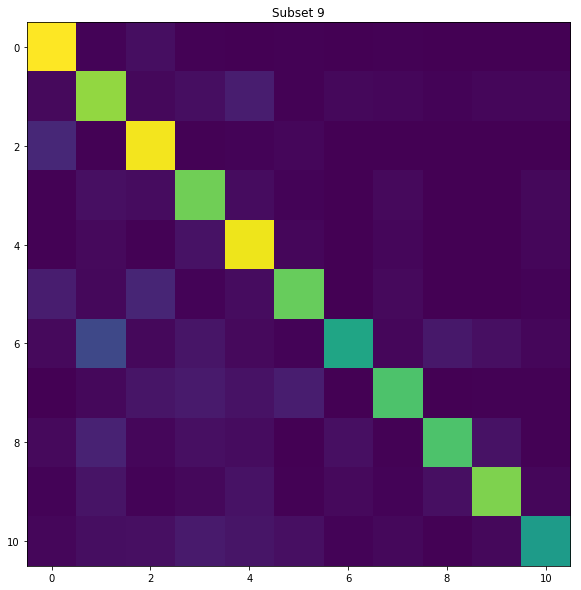

Legend:
  0: car
  1: background
  2: pickup_truck
  3: articulated_truck
  4: bus
  5: work_van
  6: pedestrian
  7: single_unit_truck
  8: bicycle
  9: motorcycle
  10: non-motorized_vehicle

Overall average accuracy is 95.52%
Standard deviation is 0.001789
Overall average precision is 76.97%
Overall average recall is 75.22%

Done, total duration: 1:00:14.706057


In [7]:
print("Updates:")

print("  Note: ")
print("    This is the non-deep learning implementation of the classifier.")
print("    In this implementation we use a kneighbor classifier")
print("    Precision: Of the predictions made for class C, what fraction was correct?")
print("    Recall: ”Of the samples for class C, how many were correctly predicted?\n")
print("  Classifiers can be loaded if files kNeighborsclassifier_0.sav - kNeighborsclassifier_9.sav are in the same" 
     + " folder as this .ipynb file.\n")

realStart = datetime.time(datetime.now())

numSubset = 10

subsetSize = featuresArray.shape[0]//numSubset
    
accuracyArray = []
precisionArray = []
recallArray = []

sqrdDiff = []

while(1):
    inputStr = input("Would you like to build or load the kNeighbors classifiers? ")
    
    inputStr = inputStr.lower()
    
    if inputStr == 'exit':
        print("  Program exiting\n")
        break
    
    elif inputStr == 'help':
        print("  Available commands: Build, Load, Help, Exit\n")
    
    elif inputStr == 'build' or inputStr == 'load':
        # proceed and build or load classifiers
        realStart = datetime.time(datetime.now())
       
        for subsetIndex in range(numSubset):
            
            precArray = []
            recArray = []
            
            data_test = featuresArray[subsetIndex*subsetSize:(subsetIndex+1)*subsetSize]
            labels_test = labelsArray[subsetIndex*subsetSize:(subsetIndex+1)*subsetSize]
    
            data_train = np.concatenate((featuresArray[:subsetIndex*subsetSize], 
                                         featuresArray[(subsetIndex+1)*subsetSize:]), axis = 0)
            labels_train = np.concatenate((labelsArray[:subsetIndex*subsetSize], 
                                           labelsArray[(subsetIndex+1)*subsetSize:]), axis = 0)
    
        #     print("data_train shape:", data_train.shape)
        #     print("d")
    
            ################################################
            """Building the classifiers"""
            if inputStr == 'build':
                while(subsetIndex==0):
                    inputSave = input("  Would you like to save the classifiers? ")
                    inputSave = inputSave.lower()
                    
                    if inputSave == 'no':
                        save = 0
                        print("    Classifiers will not be saved\n")
                        break
                    
                    elif inputSave == 'yes':
                        save = 1
                        print("    Classifiers will be saved\n")
                        break
                    
                    else:
                        print("    Invalid input -> 'yes' or 'no'\n")
                    
                print("\n  Creating classifier " + str(subsetIndex))
                start = datetime.time(datetime.now())
                clf_kneighbors = neighbors.KNeighborsClassifier(3)
                clf_kneighbors.fit(data_train, labels_train)
                end = datetime.time(datetime.now())
                print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
                
                """Saving the classifiers"""
                if save == 1:
                    filename = ('kNeighborsclassifier_%i.sav' % subsetIndex)
                    print("  Saving classifier " + str(subsetIndex) + " as >>" + filename + "<<")
                    joblib.dump(clf_kneighbors, filename)

            ################################################
            
            ################################################
            
            elif inputStr == 'load':
                """Loading the classifiers"""
                filename = ('kNeighborsclassifier_%i.sav' % subsetIndex)
                print("\n  Loading classifier >>" + filename + "<<")
                clf_kneighbors = joblib.load(filename)
            ################################################
    
            print("  Getting predictions for classifier " + str(subsetIndex))
            start = datetime.time(datetime.now())
            prediction = clf_kneighbors.predict(data_test)
            end = datetime.time(datetime.now())
            print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
    
            # Precision
            # for each class, get the precision (then average of all classes for all subset?)
            print("  For subset " + str(subsetIndex) + ":")
    
        #     print("prediction shape:", prediction.shape)
    
            totalTP = 0
            totalTN = 0
    
            for category in range(numCategories):
                TP = 0
                FP = 0
                FN = 0
                TN = 0
                for n in range(len(prediction)):
                    if prediction[n] == category:
                        if labels_test[n] == category:
                            # got a true positive
                            TP += 1
                            totalTP += 1
                        else:
                            # got a false positive
                            FP += 1
                        continue
    
                    if prediction[n] != category:
                        if labels_test[n] == category:
                            # got a false negative
                            FN += 1
                        else:
                            # got a true negative
                            TN += 1
                            totalTN += 1
                        continue
    
                    else: print("    Error at n=" + str(n) + "-> Predicted: " + str(prediction[n])
                                + ", Correct: " + str(labels_test[n]))
    
                print("    For category " + str(categoriesTest[category]) + ": TP=" + str(TP) + ", FP=" + str(FP) 
                      + ", FN=" + str(FN) + ", TN=" + str(TN))
    
                accuracyCalc = (TP+TN)/(TP+TN+FP+FN)*100
                precision = TP/(TP+FP)*100
                recall = TP/(TP+FN)*100
                
                precArray.append(precision)
                recArray.append(recall)
    
                print("      Accuracy = %.2f" % accuracyCalc + "%", end='')
                print("      Precision = %.2f" % precision + "%", end='')
                print("      Recall = %.2f" % recall + "%")
    
            subAcc = (totalTP+totalTN)/len(prediction)*100/numCategories
            print("  Average accuracy of subset %i = %.2f" % (subsetIndex, subAcc) + "%")
            accuracyArray.append(subAcc)
            
            subPrec = np.sum(precArray)/numCategories
            print("  Average precision of subset %i = %.2f" % (subsetIndex, subPrec) + "%")
            precisionArray.append(subPrec)
            
            subRecall = np.sum(recArray)/numCategories
            print("  Average recall of subset %i = %.2f" % (subsetIndex, subRecall) + "%")
            recallArray.append(subRecall)
    
            # Confusion Matrix for last subset only
            ################################################
            # Do we only need one?
            ################################################
            if subsetIndex == numSubset-1:
                print("  Creating confusion matrix " + str(subsetIndex))
                start = datetime.time(datetime.now())
                confMat = confusion_matrix(labels_test, prediction)
                end = datetime.time(datetime.now())
                print("    Duration: " + str(datetime.combine(date.today(), end) - datetime.combine(date.today(), start)))
    
                plt.figure(figsize=(10,10))
                plt.imshow(confMat), plt.title("Subset " + str(subsetIndex))
                plt.show()
    
                # display categories and their label
                print("Legend:")
                for cat in range(len(categoriesTest)):
                    print("  " + str(cat) + ": " + str(categoriesTest[cat]))
    
        # calculate the overall average accuracy
        avgAccuracy = 0
        avgAccuracy = np.sum(accuracyArray)/len(accuracyArray)
        print("\nOverall average accuracy is %.2f" % (avgAccuracy) + "%")
        
        # calculate the standard deviation
        accArray = np.asarray(accuracyArray)
        sqrdDiff = ((accArray-avgAccuracy)/100)**2
        stdDev = np.sqrt(np.sum(sqrdDiff)/len(sqrdDiff))
        print("Standard deviation is %f" % stdDev)
        
        # calculate the overall average precision
        avgPrecision = 0
        avgPrecision = np.sum(precisionArray)/len(precisionArray)
        print("Overall average precision is %.2f" % (avgPrecision) + "%")
        
        # calculate the overall average recall
        avgRecall = 0
        avgRecall = np.sum(recallArray)/len(recallArray)
        print("Overall average recall is %.2f" % (avgRecall) + "%")
    
        realEnd = datetime.time(datetime.now())
        print("\nDone, total duration: " + str(datetime.combine(date.today(), realEnd) 
                                               - datetime.combine(date.today(), realStart)))
        break
    
    else:
        # not a valid input
        print("  '" + inputStr + "' is not a valid input -> type 'help' for help\n")